In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import cvxpy as cp

from decentr_quad_no_constraint import *
import ciropt as co

In [2]:
# random seed
np.random.seed(108)

# data generation
problem_spec = {}
problem_spec['n_node'] = 6
problem_spec['vector_size'] = 10
# problem_spec['vector_size'] = 50
problem_spec['sc_theta'] = 0.5
problem_spec['sc_perturb'] = False
# problem_spec['sc_index_set'] = {0,1,2,3,4,5}
problem_spec['sc_index_set'] = {3,4}
# problem_spec['sc_index_set'] = {}
print(problem_spec)
problem_data = data_generation(problem_spec)
network_data = graph_generation_nodes6()
problem_data['itr_num'] = 1000


{'n_node': 6, 'vector_size': 10, 'sc_theta': 0.5, 'sc_perturb': False, 'sc_index_set': {3, 4}}


In [3]:
Q = problem_data['Q']
b = problem_data['b']
n_node = problem_spec['n_node']
vector_size = problem_spec['vector_size']
sc_index_set = problem_spec['sc_index_set']

for j in range(n_node):
    U, s, V = np.linalg.svd(Q[j])
    print([np.max(s), np.average(s), np.min(s)])

[0.3405863206927442, 0.12957518461608636, 0.0025719666384295685]
[0.5274069977190222, 0.13768501945306097, 9.742616763465557e-06]
[0.6264536969032102, 0.17410177421890888, 0.0010103525990530571]
[0.486682262294885, 0.16457581444769676, 0.002489724046143787]
[0.3346549375908708, 0.12521186706814363, 2.5608576311462846e-05]
[0.45764700697092076, 0.15487248278006713, 1.3259541451736755e-06]


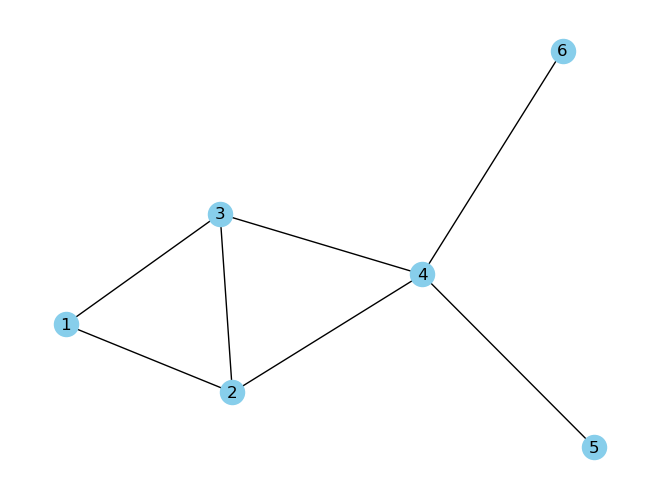

In [4]:
nx.draw(network_data["G"], node_color='skyblue', with_labels=True)
plt.savefig("plots/graph_n6.pdf")

In [5]:
f_star, x_opt_star = min_cvx_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-0.013884304414562542, np.linalg.norm(x_opt_star)=0.18790515827179746


In [6]:
f_star, x_opt_star = min_quad_no_constraint(problem_spec, problem_data)
print(f"{f_star=}, {np.linalg.norm(x_opt_star)=}")

f_star=-0.013884304414562539, np.linalg.norm(x_opt_star)=0.18790515827179746


In [7]:
Q = problem_data['Q']
b = problem_data['b']
 
vector_size = problem_spec['vector_size']
n_node = problem_spec['n_node']
prox_operators = []
fi_operators = []

# Define functions and proximal operators to implement the method
for jj in range(n_node):
    Qj = Q[jj]
    bj = b[jj]
    # prox_operators += [lambda z, rho: cvx_prox_fj_quad_no_constraint(z, rho, problem_spec, problem_data, jj) ]
    prox_operators += [lambda z, rho, Qj=Qj, bj=bj, vector_size=vector_size : prox_fj_quad_no_constraint(z, rho, Qj, bj, vector_size) ]
    fi_operators += [lambda x_kj, Qj=Qj, bj=bj : 1/2 * x_kj @ Qj @ x_kj.T + np.dot(bj[0], x_kj) ]

    c = np.random.randn(vector_size)
    x1 = prox_operators[-1](c, 1/5)
    x2 = cvx_prox_fj_quad_no_constraint(c, 1/5, problem_spec, problem_data, jj, eps=1e-4)
    assert np.linalg.norm(x1 - x2) / np.linalg.norm(x1) < 1e-5

In [8]:
# problem_data['rho'] = 1
# params={"R":1, "Capacitance":1, "h":0.561455037879421}

# pg_c_op_norm, pg_c_err_opt_star, pg_c_err_opt_reldiff, pg_c_const_vio, pg_c_f_reldiff = co.pg_extra("pg_extra_c", problem_spec, problem_data, 
#                                                                         network_data, x_opt_star, f_star, prox_operators=prox_operators,
#                                                                         fi_operators=fi_operators,
#                                                                         params=params, printing=True, sc_index_set = sc_index_set, freq=200)

In [9]:
# apply P-EXTRA 
best_rho = 1
find_best = True

# problem_data['rho'] = 0.01
# problem_data['rho'] = 0.1
# problem_data['rho'] = 0.2
# problem_data['rho'] = 0.5

# start = 0.2
start = 0.1
end = 2
space = 0.1

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        problem_data['rho'] = round(r, 2)
        # print("Testing rho :", r)
        pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        printing=False, freq=200)
        # new_val = sum(pg_f_reldiff[-10:]) / 10
        # new_val = sum(pg_f_reldiff[-300:]) / 300
        # new_val = sum(pg_f_reldiff[-300:-200]) / 100
        new_val = sum(pg_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_rho :", round(r, 2),  "new best_value :", new_val)
            best_value = new_val
            best_rho = round(r, 2)

print("best_rho :",best_rho)

new best_rho : 0.1 new best_value : 0.0011601653114228702
new best_rho : 0.2 new best_value : 2.6939566400032604e-06
new best_rho : 0.3 new best_value : 1.2357377787436008e-06
new best_rho : 0.4 new best_value : 2.110932417958556e-07
new best_rho : 0.5 new best_value : 3.108249885981729e-08
new best_rho : 0.6 new best_value : 4.1275606134704844e-09
new best_rho : 0.7 new best_value : 5.454904909827179e-10
new best_rho : 0.8 new best_value : 2.7278251798927455e-10
new best_rho : 0.9 new best_value : 1.9713693146325436e-10
new best_rho : 1.0 new best_value : 1.6695895591551772e-10
new best_rho : 1.1 new best_value : 1.4933815638203817e-10
new best_rho : 1.2 new best_value : 1.332381164939258e-10
new best_rho : 1.3 new best_value : 1.175860462522569e-10
new best_rho : 1.4 new best_value : 1.0251707220552264e-10
new best_rho : 1.5 new best_value : 8.8597214816926e-11
new best_rho : 1.6 new best_value : 7.705848806842505e-11
new best_rho : 1.7 new best_value : 6.7392886754534e-11
new best_r

In [10]:
problem_data['rho'] = best_rho
# problem_data['rho'] = 1


# pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = p_extra_quad_no_constraint(problem_spec, problem_data, network_data, x_opt_star, f_star, printing=True, freq=200)

pg_op_norm, pg_err_opt_star, pg_err_opt_reldiff, pg_const_vio, pg_f_reldiff = co.pg_extra("pg_extra", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        printing=True, freq=200)

ii=0, f_reldiff[-1]=0.8672677635189769, err_opt_reldiff[-1]=0.8389844593497342
ii=200, f_reldiff[-1]=8.520363246979436e-08, err_opt_reldiff[-1]=3.9217097071504697e-07
ii=400, f_reldiff[-1]=5.022641513184141e-13, err_opt_reldiff[-1]=4.770516609354161e-13
ii=600, f_reldiff[-1]=3.7482399352120457e-16, err_opt_reldiff[-1]=4.514479643726729e-14
ii=800, f_reldiff[-1]=3.7482399352120457e-16, err_opt_reldiff[-1]=5.919560181176571e-14
ii=999, f_reldiff[-1]=1.2494133117373487e-16, err_opt_reldiff[-1]=7.41548598537213e-14


In [11]:
best_R = 1
find_best = True

# R = 18
start = 3
end = 4
space = 0.2
# end = 2
# space = 0.1

best_value = 1

if find_best == True:
    for r in np.arange(start, end, space) :
        R = round(r, 2)
        # print("Testing R :", r)
        admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                                network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                                fi_operators=fi_operators,
                                                                                params={"R":R}, printing=False, freq=200)
        # new_val = sum(admm_f_reldiff[-10:]) / 10
        # new_val = sum(admm_f_reldiff[-300:]) / 300
        # new_val = sum(admm_f_reldiff[-300:-200]) / 100
        new_val = sum(admm_f_reldiff[300:400]) / 100
        if new_val < best_value:
            print("new best_R :", round(r, 2),  ", new best_value :", new_val)
            best_value = new_val
            best_R = round(r, 2)

print("best_R :", best_R)

new best_R : 3.0 , new best_value : 1.0982343010171286e-15
new best_R : 3.2 , new best_value : 2.6987327533526755e-16
new best_R : 3.4 , new best_value : 1.4618135747327006e-16
new best_R : 3.6 , new best_value : 8.371069188640235e-17
best_R : 3.6


In [12]:
R = best_R
# R = 3
# R = 2
# R = 1
# R = 0.5
admm_err_opt_star, admm_err_opt_reldiff, admm_const_vio, admm_f_reldiff = co.dadmm("dadmm", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        params={"R":R}, printing=True, freq=200)


ii=0, f_reldiff[-1]=1.2706344977442008
ii=200, f_reldiff[-1]=2.23932347862685e-12
ii=400, f_reldiff[-1]=1.2494133117373487e-16
ii=600, f_reldiff[-1]=1.2494133117373487e-16
ii=800, f_reldiff[-1]=0.0
ii=999, f_reldiff[-1]=1.2494133117373487e-16


In [13]:
problem_data['rho'] = best_rho
# params={"R":1, "Capacitance":1, "h":0.561455037879421}
params={"R":best_rho, "Capacitance":1, "h":0.561455037879421}
# params={"R":best_rho, "Capacitance":0.1, "h":0.7}

# problem_data['rho'] = 0.0001
# params={"R":best_rho, "Capacitance":0.1, "h":0.7}



pg_c_op_norm, pg_c_err_opt_star, pg_c_err_opt_reldiff, pg_c_const_vio, pg_c_f_reldiff = co.pg_extra("pg_extra_c", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        params=params, printing=True, sc_index_set = sc_index_set, freq=200)

ii=0, f_reldiff[-1]=0.8241705253540536, err_opt_reldiff[-1]=0.8284450036087231
ii=200, f_reldiff[-1]=0.0001387955381082561, err_opt_reldiff[-1]=8.744583004427534e-05
ii=400, f_reldiff[-1]=1.6899601562134737e-08, err_opt_reldiff[-1]=2.3886183654243115e-08
ii=600, f_reldiff[-1]=8.88607735573837e-12, err_opt_reldiff[-1]=6.1747676091145075e-12
ii=800, f_reldiff[-1]=1.874119967606023e-15, err_opt_reldiff[-1]=1.669597527437338e-15
ii=999, f_reldiff[-1]=3.7482399352120457e-16, err_opt_reldiff[-1]=3.516372978580398e-16


In [30]:
problem_data['rho'] = best_rho
# params['S'] = 1
params['S'] = -0.1

pg_R_op_norm, pg_R_err_opt_star, pg_R_err_opt_reldiff, pg_R_const_vio, pg_R_f_reldiff = co.pg_extra("pg_extra_R", problem_spec, problem_data, 
                                                                        network_data, x_opt_star, f_star, prox_operators=prox_operators,
                                                                        fi_operators=fi_operators,
                                                                        params=params, printing=True, sc_index_set = sc_index_set, freq=200)

ii=0, f_reldiff[-1]=0.86924208355275, err_opt_reldiff[-1]=0.8390206577244673
ii=200, f_reldiff[-1]=0.0005554947772724648, err_opt_reldiff[-1]=0.017465420219925795
ii=400, f_reldiff[-1]=0.0005555884138536914, err_opt_reldiff[-1]=0.017465420081112393
ii=600, f_reldiff[-1]=0.0005555884143089776, err_opt_reldiff[-1]=0.01746542008107423
ii=800, f_reldiff[-1]=0.0005555884143086028, err_opt_reldiff[-1]=0.01746542008107215
ii=999, f_reldiff[-1]=0.0005555884143087278, err_opt_reldiff[-1]=0.017465420081069667


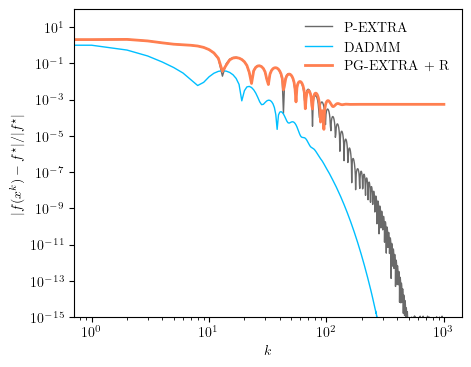

In [31]:
fname = "n6_qp_circuit_pg_c"

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 4
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["mathtext.fontset"] = 'cm' # default = 'dejavusans', other options = 'cm', 'stixsans', 'dejavuserif'
black, red, blue, green = 'dimgrey', 'coral', 'deepskyblue', 'green'

# operator norm plot (log-log plot)
plt.figure(figsize=(5,4))
plt.minorticks_off()
plt.xscale("log")
plt.yscale("log")
plt.plot(pg_f_reldiff, label='P-EXTRA', color=black, linewidth=1)
plt.plot(admm_f_reldiff, label='DADMM', color=blue, linewidth=1)
# plt.plot(dadmm_c_all_f_reldiff, label='Circuit DADMM + C-All',  color=green, linewidth=1)
# plt.plot(dadmm_c_f_reldiff, label='Circuit DADMM + C',  color=red, linewidth=2)
# plt.plot(pg_c_f_reldiff, label='PG-EXTRA + C',  color=red, linewidth=2)
plt.plot(pg_R_f_reldiff, label='PG-EXTRA + R',  color=red, linewidth=2)
plt.xlabel(r"$k$")
plt.ylabel(r"$|f(x^k) - f^\star|/|f^\star|$")
# plt.ylabel(r"$\|\tilde{\mathbf{A}}x_k\|^2_M$")
plt.ylim(1e-15, 1e+2)
# plt.autoscale(enable=True, axis='y', tight=None)
plt.legend()
plt.savefig(f'plots/freldif_{fname}.pdf', dpi=300)